<a href="https://colab.research.google.com/github/null32/ML1/blob/master/lect/colab_copy/AdaBoost_03_11_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Пример использования для классификации объектов

In [ ]:
#!/usr/bin/env python3

import csv
import itertools as it
import os
import numpy as np
import random as rng
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

def main():
    # X, Y = random_data()
    X, Y = wine_data()

    ada_classifier = AdaBoostClassifier(n_estimators= 60, random_state= 0)
    ada_classifier.fit(X, Y)

    i = rng.randint(0, len(Y))
    testX = np.array([X[i]])
    testY = Y[i]
    predicted = ada_classifier.predict(testX)[0]

    print(f'Random object from data set:[', ', '.join([f'{x:.3f}' for x in X[i]]), ']')
    print(f'Ada boost predicted: {predicted}, real value: {testY}')

def random_data():
    X, Y = make_classification(
        n_samples= 1000,
        n_features= 5,
        n_informative= 3,
        n_redundant= 0,
        shuffle= False
    )
    return X, Y

def wine_data(red_or_white = True):
    data_path = f'drive/MyDrive/Colab Notebooks/sample_data/winequality-{"red" if red_or_white else "white"}.csv'
    data_file = open(data_path,'r')
    data_reader = csv.reader(data_file, delimiter=';')

    # header
    _ = data_reader.__next__()
    wine_data = list(map(lambda c: [float(e) for e in c], data_reader))
    data_file.close()

    X = np.array(list(map(lambda c: c[:-1], wine_data)))
    Y = np.array(list(map(lambda c: c[-1], wine_data)))
    return X, Y

if __name__ == "__main__":
    main()

Random object from data set:[ 5.800, 0.610, 0.110, 1.800, 0.066, 18.000, 28.000, 0.995, 3.550, 0.660, 10.900 ]
Ada boost predicted: 6.0, real value: 6.0


## Классификация 2 линейно неразделимых классов

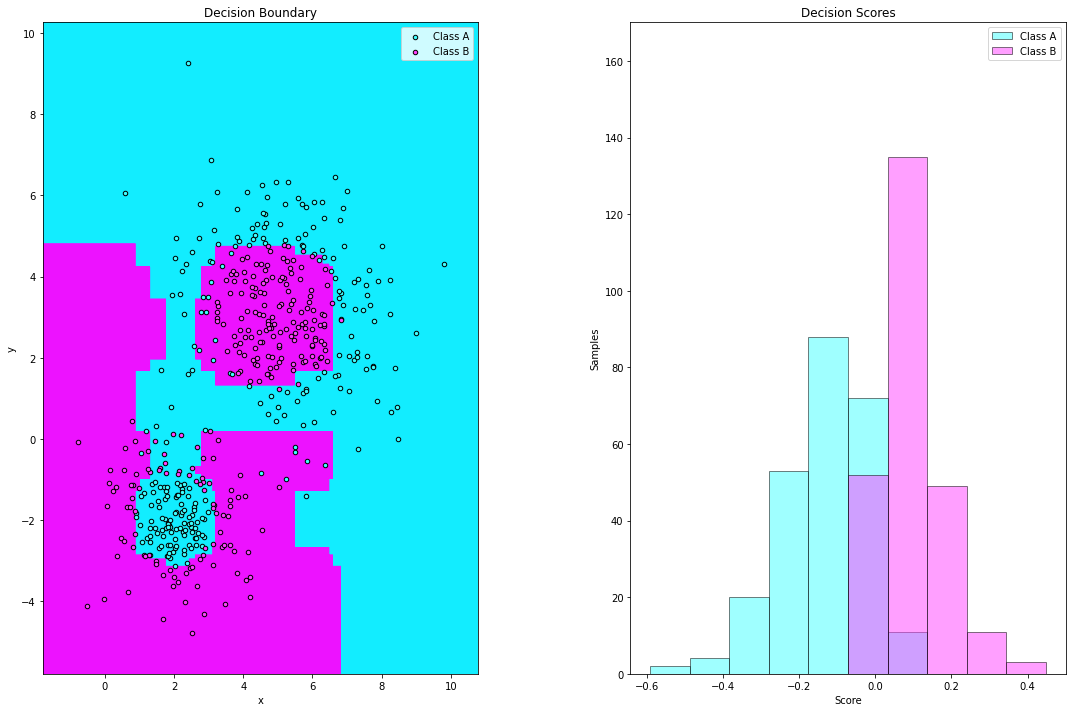

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

# cyan
X1, Y1 = make_gaussian_quantiles(
    n_features = 2, n_classes = 2,
    n_samples = 200,
    cov = 1,
    mean = (2, -2),
    random_state = 1
)
# magenta
X2, Y2 = make_gaussian_quantiles(
    n_features = 2, n_classes=2,
    n_samples = 300,
    cov = 2.5,
    mean = (5, 3),
    random_state = 1
)
# dataset
X = np.concatenate((X1, X2))
Y = np.concatenate((Y1, 1 - Y2))

bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    algorithm = "SAMME",
    n_estimators = 200
)

bdt.fit(X, Y)

plot_colors = ["#40FFFF", "#FF40FF"]
plot_step = 0.02
class_names = "AB"
cmap = 'cool'
# Plot size
plt.figure(figsize = (15, 10))

# Plot boundaries
plt.subplot(1, 2, 1)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, plot_step),
    np.arange(y_min, y_max, plot_step)
)

# Predict surface
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap = cmap)
plt.axis("tight")

# Plot data
for i in range(2):
    cl_name = class_names[i]
    pl_color = plot_colors[i]
    indexes = np.where(Y == i)
    plt.scatter(
        X[indexes, 0], X[indexes, 1],
        c = pl_color, cmap = cmap,
        s = 20, edgecolors = 'k',
        label = f'Class {cl_name}')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc = 'upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(1, 2, 2)
for i in range(2):
    cl_name = class_names[i]
    pl_color = plot_colors[i]
    plt.hist(
        twoclass_output[Y == i],
        bins = 10, range = plot_range,
        facecolor = pl_color,
        alpha = 0.5, edgecolor = 'k',
        label = f'Class {cl_name}'
    )

x1, x2, Y1, Y2 = plt.axis()
plt.axis((x1, x2, Y1, Y2 * 1.2))
plt.legend(loc = 'upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

## Применение AdaBoos для классификации с несколькими классами


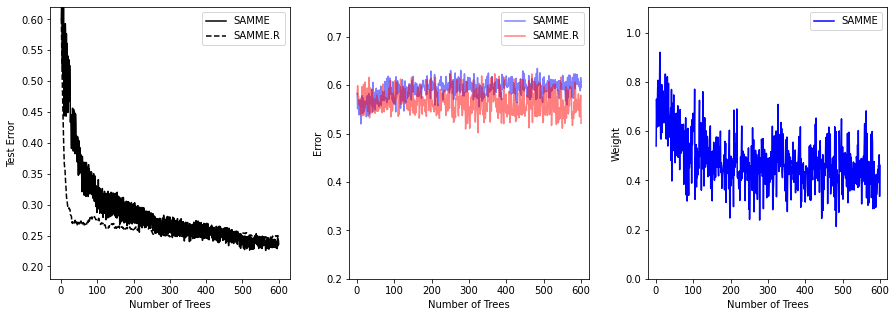

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# dataset
X, Y = make_gaussian_quantiles(
    n_classes = 3, n_features=10,
    n_samples = 13000,
    random_state = 1
)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
Y_train, Y_test = Y[:n_split], Y[n_split:]

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 2),
    n_estimators = 600,
    learning_rate = 1
)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 2),
    n_estimators = 600,
    learning_rate = 1.5,
    algorithm = "SAMME"
)

bdt_real.fit(X_train, Y_train)
bdt_discrete.fit(X_train, Y_train)

real_test_errors = []
discrete_test_errors = []

for predict_real, predict_disc in zip(bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)):
    real_test_errors.append(1.0 - accuracy_score(predict_real, Y_test))
    discrete_test_errors.append(1.0 - accuracy_score(predict_disc, Y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c = 'black', label = 'SAMME')
plt.plot(range(1, n_trees_real + 1), real_test_errors, c = 'black', linestyle = 'dashed', label = 'SAMME.R')
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel('Test Error')
plt.xlabel('Number of Trees')

plt.subplot(1, 3, 2)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_errors, "b", label = 'SAMME', alpha = 0.5)
plt.plot(range(1, n_trees_real + 1), real_estimator_errors, "r", label = 'SAMME.R', alpha = 0.5)
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.ylim((0.2,
    max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2)
)
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(1, 3, 3)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label = 'SAMME')
plt.legend()
plt.ylabel('Weight')
plt.xlabel('Number of Trees')
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace = 0.25)
plt.show()